In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import seaborn as sns

In [2]:
#Ob_set is the Obesity set of date. It has the obesity rates from 2004 - 2012 per county
#Lets load in the data toutilize it further
#"number yyyy" is the percentage of obese idividuals based on the surverys done each year for the entire county
Ob_set = pd.read_excel("OB_PREV_ALL_STATES.xlsx", "obesity")

In [3]:
#Remove all the extra data in the Obesity list to leave just the numbers and % obese per county
for col in Ob_set.columns[4:]:
    if 'number' not in col and 'percent' not in col or 'age' in col:
        del Ob_set[col]

In [4]:
#Add a column to the Ob_set full of 0s to be counted up for each county in the FarmMkt list
#Ob_set['FarmersMkts Per County'] = pd.Series(0, index=Ob_set.index)

In [5]:
#FarmMkt is the set of farmers markets in the US
#Pull in the data to find the farmers market density per county
FarmMkt = pd.read_csv("Farmers_market_Dir.csv")

In [6]:
#Drop (remove) the columns in the farmers market data set that we dont need
#remove all coumns but 9 & 10
FarmMkt = FarmMkt.drop(FarmMkt.columns[1:8], axis=1)#,inplace=True)
FarmMkt = FarmMkt.drop(FarmMkt.columns[4:], axis=1)
FarmMkt = FarmMkt.dropna(subset=['County'], how='all') #drop all rows that have any NaN values

In [7]:
#make a new column in FarmMkt and Ob_set to be a key to match the county/state pair
Ob_set['CSKey'] = Ob_set[['County','State']].sum(axis=1)
FarmMkt['CSKey'] = FarmMkt[['County','State']].sum(axis=1)

In [8]:
#New frame for the group by for the farmers market data
NewFrame = FarmMkt.groupby('CSKey').count()
NewFrame = NewFrame.drop(NewFrame.columns[1:], axis=1)
NewFrame.columns = ['FarmersMkts Per County']
#then merge it with the OBesity set to have the Fearmers market counts
#Ob_set['FarmersMkts Per County'] = Ob_set.merge(NewFrame, on=NewFrame.index, how='left')
Ob_set = pd.merge(Ob_set, NewFrame, how='left', left_on='CSKey',left_index=False, right_index=True, sort=True, copy=True)
#then drop the Key from the Ob_set data as no longer needed
#Ob_set = Ob_set.drop(Ob_set.columns[Ob_set.columns.get_loc('CSKey')], axis=1)
#dont drop this yet - need it for the next set of data

In [9]:
#Change all the Nan values in the Famers count to 0
Ob_set['FarmersMkts Per County'] = Ob_set['FarmersMkts Per County'].fillna(int(0))
#Change all the Farmers market vals to ints
Ob_set['FarmersMkts Per County'] = Ob_set['FarmersMkts Per County'].astype(int)

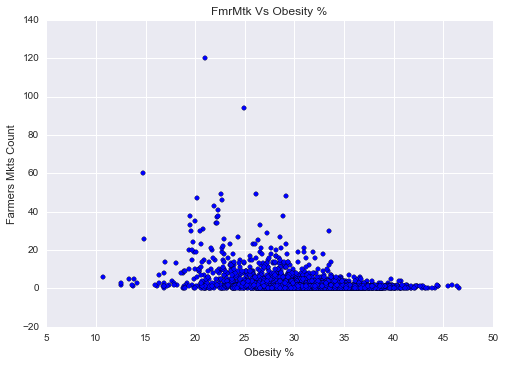

In [10]:
import matplotlib.pyplot as pltFMOb
pltFMOb.xlabel('Obesity %')
pltFMOb.ylabel('Farmers Mkts Count')
pltFMOb.title('FmrMtk Vs Obesity %')
pltFMOb.scatter(Ob_set['percent 2012'], Ob_set['FarmersMkts Per County'], label="training points")

In [11]:
Ob_set['LogFM'] = np.log(Ob_set['FarmersMkts Per County'].values)
Ob_set['LogPC'] = np.log(Ob_set['percent 2012'].values)

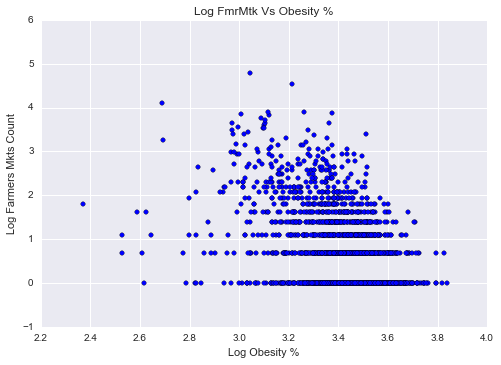

In [12]:
import matplotlib.pyplot as pltFMOb
pltFMOb.xlabel('Log Obesity %')
pltFMOb.ylabel('Log Farmers Mkts Count')
pltFMOb.title('Log FmrMtk Vs Obesity %')
pltFMOb.scatter(Ob_set['LogPC'], Ob_set['LogFM'], label="training points")

In [13]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
log_lm = linear_model.LinearRegression()

In [14]:
#take all the X values (in this case the obesity percent) and take them to the every power up to the 7th
#so that we can use these values in our plotting
Obper = (Ob_set['percent 2012'])
XObper = np.column_stack((Obper, 
                          np.power(Obper, 2), 
                          np.power(Obper, 3),
                          np.power(Obper, 4),
                          np.power(Obper, 5),
                          np.power(Obper, 6),
                          np.power(Obper, 7)))

# xvals is a vector of length 100 spanning from 5 and 50
# We use this as the x-values for a grid
# We will find y values to plot against these to sketch out the 7th deg function.
xvals = np.linspace(5,50,100)

# X_vals is the design matrix with all the 100 grid values
# With added columns of those grid values raised to the 2nd, 3rd, .. 7th power.
X_vals = np.column_stack((xvals, 
                     np.power(xvals, 2), 
                     np.power(xvals, 3),
                     np.power(xvals, 4),
                     np.power(xvals, 5),
                     np.power(xvals, 6),
                     np.power(xvals, 7)))

ys = np.vstack(Ob_set['FarmersMkts Per County'].tolist())

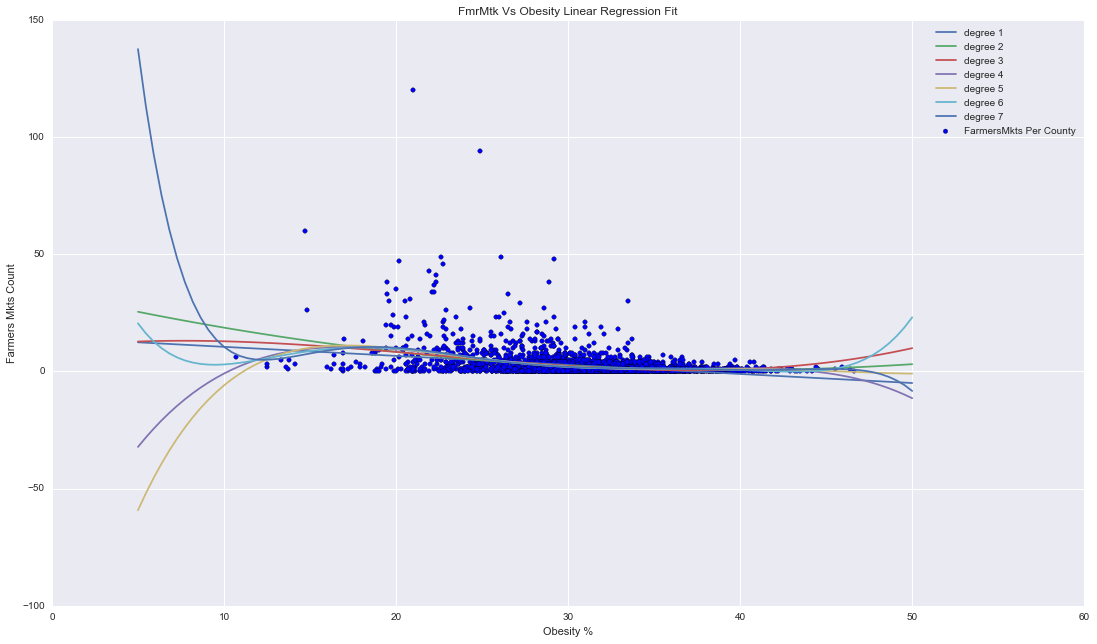

In [15]:
#Linear Regression of the Farmers Market Denisty per County and Obesity Rate. Per County
pltFMOb.scatter(Ob_set['percent 2012'], Ob_set['FarmersMkts Per County'])
LRscore = []

for degree in [1,2,3,4,5,6,7]:
    lmFMOB = LinearRegression()
    lmFMOB.fit(XObper[:,:degree], ys)
    pred = lmFMOB.predict(X_vals[:,:degree])
    pltFMOb.plot(np.array(xvals), pred, label="degree %d" % degree)
    LRscore.append(lmFMOB.score(XObper[:,:degree], ys))

pltFMOb.xlabel('Obesity %')
pltFMOb.ylabel('Farmers Mkts Count')
pltFMOb.title('FmrMtk Vs Obesity Linear Regression Fit')
pltFMOb.legend(loc='upper right')
#Save the file as an image
fig = pltFMOb.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('FrmMkt_Vs_ObPer_LR.png', dpi=300)

In [16]:
print lmFMOB.intercept_
print lmFMOB.coef_
print LRscore

[ 783.69940823]
[[ -2.31627082e+02   2.78203777e+01  -1.75305086e+00   6.30981881e-02
   -1.30815714e-03   1.45621340e-05  -6.74920856e-08]]
[0.10600412271158455, 0.12509365362261404, 0.12847462177258184, 0.13910968034817917, 0.14001867548716207, 0.14176995710180251, 0.14274707651026963]


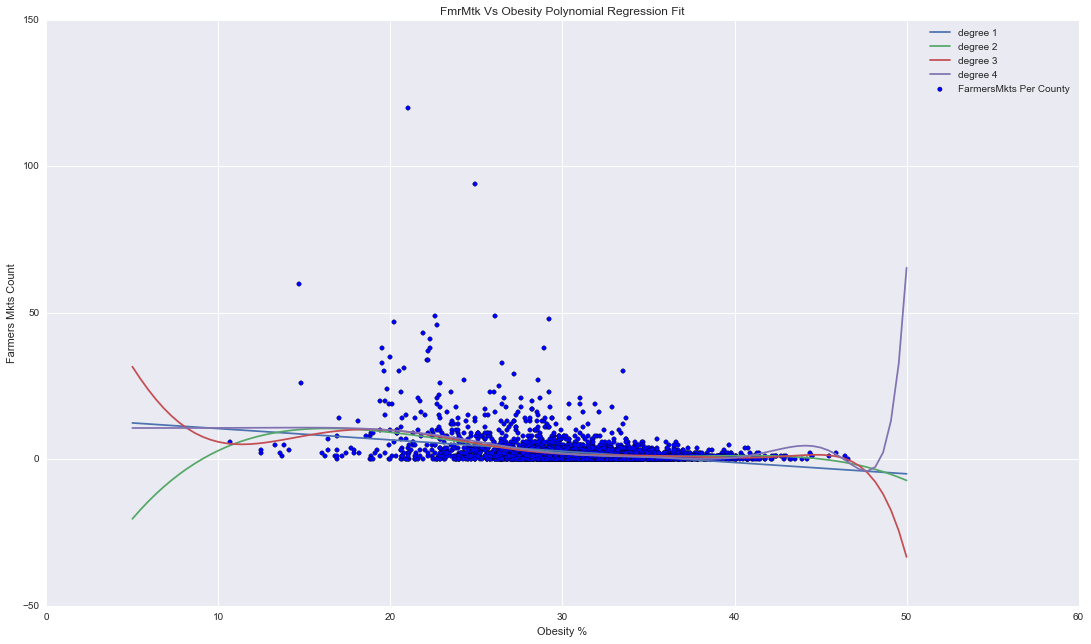

In [17]:
#polynotmail Regression Fitting
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pltFMOb.scatter(Ob_set['percent 2012'], Ob_set['FarmersMkts Per County'])
PRscore = []

for degree in [1,2,3,4]:
    pmFMOB = make_pipeline(PolynomialFeatures(degree), Ridge())
    pmFMOB.fit(XObper[:,:degree], ys)
    pred = pmFMOB.predict(X_vals[:,:degree])
    pltFMOb.plot(xvals, pred, label="degree %d" % degree)
    PRscore.append(pmFMOB.score(XObper[:,:degree], ys))
    
pltFMOb.xlabel('Obesity %')
pltFMOb.ylabel('Farmers Mkts Count')
pltFMOb.title('FmrMtk Vs Obesity Polynomial Regression Fit')
pltFMOb.legend(loc='upper right')
#Save the file as an image
fig = pltFMOb.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('FrmMkt_Vs_ObPer_PR.png', dpi=300)

In [18]:
print PRscore

[0.10600412268453729, 0.13850319902920927, 0.14288862711952732, 0.13268373247497089]


In [19]:
#GrocStore is the set of food stores in the US
#Pull in the data to find the grocery and supercenters
FoodSecStore = pd.read_excel("FoodSecAllup.xls", 'STORES')
FoodSecRest = pd.read_excel("FoodSecAllup.xls", 'RESTAURANTS')

In [20]:
FarmMktAll = pd.read_csv("Farmers_market_Dir.csv")
FarmMktAll.columns[[7,8,11,13,15,17,19,21,26,29,30]]
#FarmMktAll.columns[1:4]

#make a new Farmers Market set for the food types they sell to apply to the data to see if that influences anything
FarmMktFood = pd.read_csv("Farmers_market_Dir.csv")
#Drop (remove) the columns in the farmers market data set that we dont need
#remove columns except the ones that we want to evalluate
FarmMktFood = FarmMktFood.drop(FarmMktFood.columns[1:8], axis=1)
FarmMktFood = FarmMktFood.drop(FarmMktFood.columns[4:21], axis=1)
FarmMktFood = FarmMktFood.drop(FarmMktFood.columns[[4,7,8,11,13,14,15,17,18,19,21,22,23,24,25,26,29,30,31,32,33,34]], axis=1)
FarmMktFood = FarmMktFood.dropna(subset=['County'], how='all') #drop all rows that have any NaN values

FarmMktFood['CSKey'] = FarmMktFood[['County','State']].sum(axis=1) #create the CSKey column
cols = FarmMktFood.columns.tolist() #move the CSKey to the front column
cols = cols[-1:] + cols[:-1] #move the CSKey to the front column
FarmMktFood = FarmMktFood[cols] #move the CSKey to the front column
FarmMktFood = FarmMktFood.dropna(subset=['Bakedgoods'], how='all') #drop all rows that have any NaN values

In [21]:
Ob_set.head()

,State,FIPS Codes,County,number 2004,percent 2004,number 2005,percent 2005,number 2006,percent 2006,number 2007,...,number 2010,percent 2010,number 2011,percent 2011,number 2012,percent 2012,CSKey,FarmersMkts Per County,LogFM,LogPC
2311,South Carolina,45001,Abbeville,5022,26.3,5353,28.13,5629,29.7,5682,...,6525,34.8,6478,34.6,6425,34.2,AbbevilleSouth Carolina,1,0.000000,3.532226
1108,Louisiana,22001,Acadia Parish,11750,28.8,12360,29.89,12710,30.3,12500,...,13928,32.2,13995,32.3,13957,31.9,Acadia ParishLouisiana,0,-inf,3.462606
2815,Virginia,51001,Accomack,8522,29.3,8823,29.97,9232,31.3,8716,...,9056,35.5,8929,35.0,9367,36.6,AccomackVirginia,3,1.098612,3.600048
546,Idaho,16001,Ada,45240,19.0,50560,20.35,56170,21.8,58680,...,65831,23.5,70058,24.4,71992,24.5,AdaIdaho,7,1.945910,3.198673
784,Iowa,19001,Adair,1516,25.0,1633,26.76,1662,27.9,1662,...,1853,31.8,1863,32.3,1767,31.0,AdairIowa,1,0.000000,3.433987


In [22]:
#replace all the Ys and Ns with 1 and 0
FarmMktFood.ix[:,'Bakedgoods':] = FarmMktFood.ix[:,'Bakedgoods':].replace("Y", 1)
FarmMktFood.ix[:,'Bakedgoods':] = FarmMktFood.ix[:,'Bakedgoods':].replace("N", 0)
FarmMktFood.head()

,CSKey,FMID,city,County,State,Bakedgoods,Cheese,Eggs,Seafood,Vegetables,Meat,Poultry,Fruits,Grains
0,KalamazooMichigan,1000618,Kalamazoo,Kalamazoo,Michigan,1,1,1,0,1,1,1,1,0
2,BartonMissouri,1010691,Lamar,Barton,Missouri,1,0,1,0,1,1,1,1,0
3,New YorkNew York,1002454,New York,New York,New York,1,0,0,0,1,0,0,0,0
4,DavidsonTennessee,1011100,Nashville,Davidson,Tennessee,1,1,1,0,1,1,1,1,0
5,New YorkNew York,1009845,New York,New York,New York,1,1,1,0,1,1,1,1,0


In [23]:
#Add up all the values in the Baked good on as a new column and have this as a Fresh Food Count
clist = list(FarmMktFood) #list column headers 
clist.remove('FMID') #remove the FMID so we dont add it in
FarmMktFood['FFscore'] = FarmMktFood[clist].sum(axis=1)

In [24]:
#New frame2 for the group by for the farmers market data
NewFrame2 = FarmMktFood.groupby(['CSKey','FFscore']).count()
NewFrame2a = NewFrame2.drop(NewFrame2.columns[0:],axis=1)
NewFrame2a = NewFrame2a.reset_index()
NewFrame2a = NewFrame2a.set_index('CSKey')
NewFrame2a.head()

,FFscore
CSKey,
AbbevilleSouth Carolina,5
AccomackVirginia,7
AdaIdaho,4
AdaIdaho,5
AdaIdaho,6


In [23]:
#then merge NewFrame2 with the OBesity set to have the Fearmers market counts
#Ob_set['FarmersMkts Per County'] = Ob_set.merge(NewFrame, on=NewFrame.index, how='left')
Ob_set = pd.merge(Ob_set, NewFrame2a, how='left', left_on='CSKey',left_index=False, right_index=True, sort=True, copy=True)
#then drop the Key from the Ob_set data as no longer needed
Ob_set = Ob_set.drop(Ob_set.columns[Ob_set.columns.get_loc('CSKey')], axis=1)
#Change all the Nan values in the Famers count to 0
Ob_set['FFscore'] = Ob_set['FFscore'].fillna(int(0))

In [24]:
Ob_set['FFscore'] = Ob_set['FFscore'].fillna(int(0))

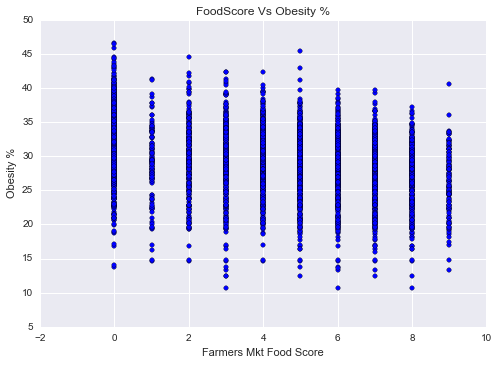

In [33]:
pltFMOb.ylabel('Obesity %')
pltFMOb.xlabel('Farmers Mkt Food Score')
pltFMOb.title('FoodScore Vs Obesity %')
pltFMOb.scatter(Ob_set['FFscore'], Ob_set['percent 2012'], label="training points")
#Apply K nearest, naive based ,random forest, and descions tree

In [26]:
#KNN for the Foodscore
from matplotlib.colors import ListedColormap
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsClassifier as KNN

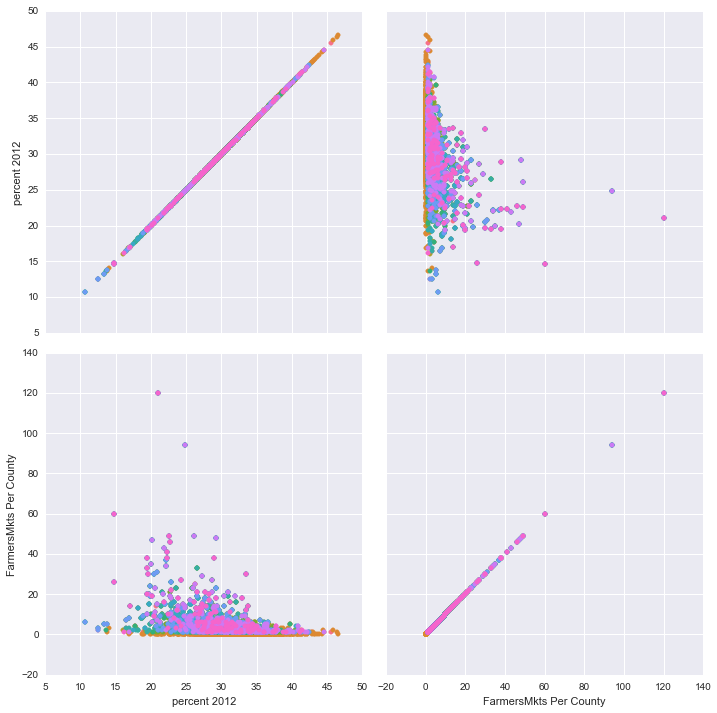

In [28]:
g = sns.PairGrid(Ob_set, vars=["percent 2012", "FarmersMkts Per County"],
                 hue="FFscore", aspect=1, size=5)
g.map(plt.scatter)

In [29]:
X = Ob_set.ix[:,:-1]
y = Ob_set.ix[:,-1]
#Correct way to split Datafrome into test and train:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.30)

In [ ]:
#KNN
#not a viable option for this

In [30]:
#set a column = to the log of the FFscroe to see if it is a better fit
Ob_set['FFscrLog'] = np.log(Ob_set['FFscore'])

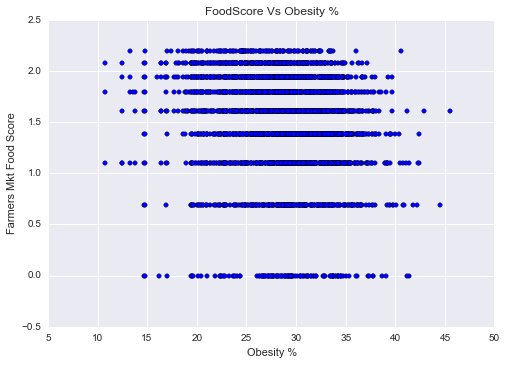

In [31]:
pltFMOb.xlabel('Obesity %')
pltFMOb.ylabel('Farmers Mkt Food Score')
pltFMOb.title('FoodScore Vs Obesity %')
pltFMOb.scatter(Ob_set['percent 2012'], Ob_set['FFscrLog'], label="training points")

#doesnt help

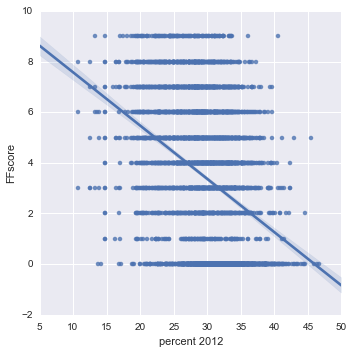

In [26]:
sns.lmplot("percent 2012", "FFscore", Ob_set);

In [32]:
Ob_set.head()

,State,FIPS Codes,County,number 2004,percent 2004,number 2005,percent 2005,number 2006,percent 2006,number 2007,...,percent 2009,number 2010,percent 2010,number 2011,percent 2011,number 2012,percent 2012,FarmersMkts Per County,FFscore,FFscrLog
2311,South Carolina,45001,Abbeville,5022,26.3,5353,28.13,5629,29.7,5682,...,32.6,6525,34.8,6478,34.6,6425,34.2,1,5,1.609438
1108,Louisiana,22001,Acadia Parish,11750,28.8,12360,29.89,12710,30.3,12500,...,32.7,13928,32.2,13995,32.3,13957,31.9,0,0,-inf
2815,Virginia,51001,Accomack,8522,29.3,8823,29.97,9232,31.3,8716,...,33.4,9056,35.5,8929,35.0,9367,36.6,3,7,1.945910
546,Idaho,16001,Ada,45240,19.0,50560,20.35,56170,21.8,58680,...,23.3,65831,23.5,70058,24.4,71992,24.5,7,4,1.386294
546,Idaho,16001,Ada,45240,19.0,50560,20.35,56170,21.8,58680,...,23.3,65831,23.5,70058,24.4,71992,24.5,7,5,1.609438


In [49]:
type Ob_set['percent 2012','FFscore','FarmersMkts Per County']

SyntaxError: invalid syntax (<ipython-input-49-485ea842a6e2>, line 1)

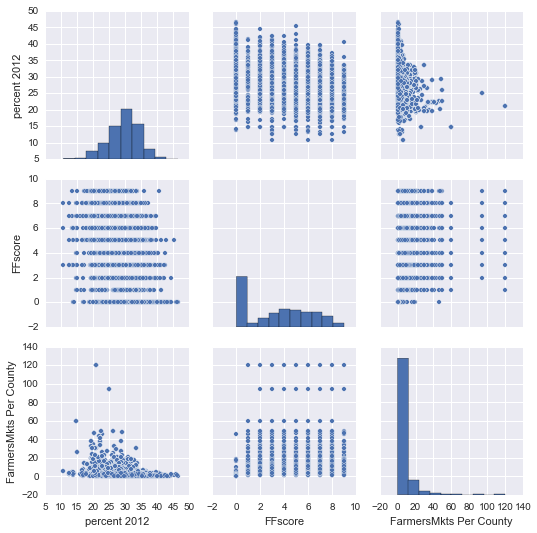

In [51]:
sns.pairplot(Ob_set, size=2.5,vars=Ob_set[['percent 2012','FFscore','FarmersMkts Per County']])